In [1]:
# - preparing the master dataframe
from typing import List, Tuple
import os, sys
sys.path.insert(0, os.path.abspath('../../'))
from tqdm import tqdm
import random
import numpy
import pandas
import matplotlib.pyplot as plt
import torch
import torch.utils.data.dataset
import torch.utils.data.dataloader

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from tabulate import tabulate
import plotly_express as px
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *


from kp_problem.dataset.tabular import fetch_dataset

In [2]:
%%time
df_features, df_targets, feature_groups = fetch_dataset(
    ewma_histories=True,
    ewma_alpha=0.8,
    ewma_adjust=True,
    prev_month=True,
    balance_by_n_rows_per_treatment=0,
)

100%|██████████| 30/30 [00:04<00:00,  7.22it/s]


CPU times: user 17.9 s, sys: 1.03 s, total: 18.9 s
Wall time: 18.9 s


Let's take a look at the features we want to pick:

In [3]:
df_features.columns.tolist()

['PatientID',
 'Timepoints',
 'Comp. NNRTI_0.0',
 'Comp. NNRTI_1.0',
 'Comp. NNRTI_2.0',
 'Comp. NNRTI_3.0',
 'Comp. INI_0.0',
 'Comp. INI_1.0',
 'Comp. INI_2.0',
 'Comp. INI_3.0',
 'Base Drug Combo_0.0',
 'Base Drug Combo_1.0',
 'Base Drug Combo_2.0',
 'Base Drug Combo_3.0',
 'Base Drug Combo_4.0',
 'Base Drug Combo_5.0',
 'Drug (M)_0.0',
 'Drug (M)_1.0',
 'Extra PI_0.0',
 'Extra PI_1.0',
 'Extra PI_2.0',
 'Extra PI_3.0',
 'Extra PI_4.0',
 'Extra PI_5.0',
 'Extra pk-En_0.0',
 'Extra pk-En_1.0',
 'Gender_1.0',
 'Gender_2.0',
 'Ethnic_2.0',
 'Ethnic_3.0',
 'Ethnic_4.0',
 'Comp. NNRTI_0.0_ewma',
 'Comp. NNRTI_1.0_ewma',
 'Comp. NNRTI_2.0_ewma',
 'Comp. NNRTI_3.0_ewma',
 'Comp. INI_0.0_ewma',
 'Comp. INI_1.0_ewma',
 'Comp. INI_2.0_ewma',
 'Comp. INI_3.0_ewma',
 'Base Drug Combo_0.0_ewma',
 'Base Drug Combo_1.0_ewma',
 'Base Drug Combo_2.0_ewma',
 'Base Drug Combo_3.0_ewma',
 'Base Drug Combo_4.0_ewma',
 'Base Drug Combo_5.0_ewma',
 'Drug (M)_0.0_ewma',
 'Drug (M)_1.0_ewma',
 'Extra PI_0.0

In [21]:
[e for e in df_features.columns if 'gender' in e.lower()]

['Gender_1.0', 'Gender_2.0']

You can scroll the above and confirm that, besides `PatientID` and `Timepoints`, everything else is a feature that is accessible at timepoint `t`. Thus, let's now consider each record separately, and via PCA and t-SNE visualizations see how do they stand compared to each other.

For the output (to visualize as gradient colors), I will use `reward_advantage`. Admittedly, there is a considerable domain-knowledge missingness on my part, and I would have loved to work on learning more about the problem if time allowed.
At this point, I make this simplifying assumption that at the moment seems reasonable to me:
* *`reward_advantage` or the difference between the final result of `reward` per timestep `t`, is the change in reward attributed to the choice of `NNRTI`.*

In [4]:
target = 'reward_advantage'
selected_features = [e for e in df_features.columns.tolist() if e not in ['PatientID', 'Timepoints']]

In [5]:
X = df_features.loc[:, selected_features].to_numpy()
y = df_targets['reward_advantage'].to_numpy()

In [6]:
def find_treatment(x):
    for i in range(4):
        if x[f'Comp. NNRTI_{i}.0']:
            return i
df_targets['treatment'] = df_features.apply(find_treatment, axis=1)

In [7]:
X_transformed = StandardScaler().fit_transform(X)

### PCA

In [8]:
%%time
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_transformed)

results_df = pandas.DataFrame(dict(
    x=X_pca_2d[:, 0],
    y=X_pca_2d[:, 1],
    treatment=df_targets['treatment'],
    reward=df_targets['reward'] - df_targets['reward'].min(),
    reward_advantage=df_targets['reward_advantage']-df_targets['reward_advantage'].min(),
    patient_id=df_features['PatientID'],
    timepoint=df_features['Timepoints']
))

CPU times: user 32.3 s, sys: 565 ms, total: 32.9 s
Wall time: 1.15 s


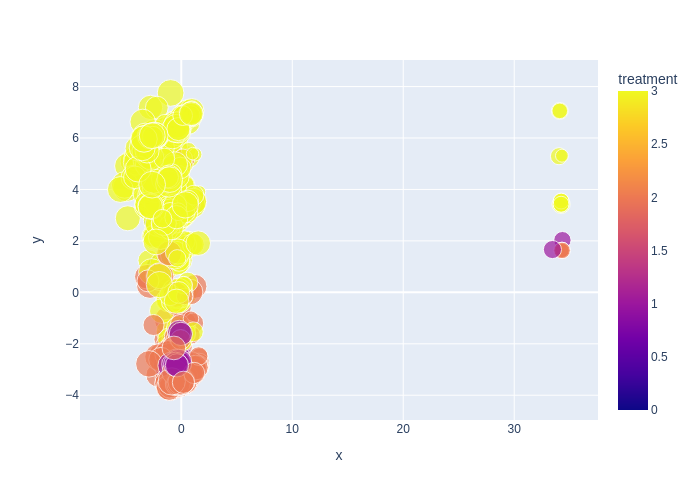

In [9]:
px.scatter(results_df.sample(1000), x='x', y='y', size='reward', color='treatment', hover_data=['patient_id', 'timepoint']).show('png')

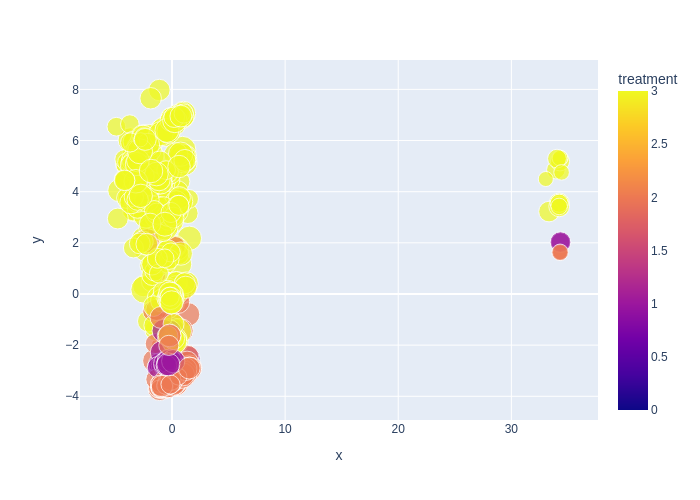

In [10]:
px.scatter(results_df.sample(1000), x='x', y='y', size='reward_advantage', color='treatment', hover_data=['patient_id', 'timepoint']).show('png')

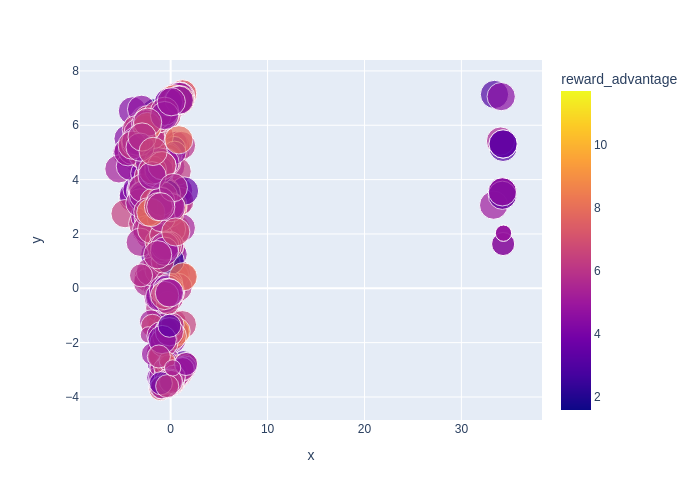

In [11]:
px.scatter(results_df.sample(1000), x='x', y='y', color='reward_advantage', size='treatment', hover_data=['patient_id', 'timepoint']).show('png')

In [12]:
df_features[
    (df_features.PatientID == 7086) & (df_features.Timepoints==0)
    
]

PatientID  Timepoints  Comp. NNRTI_0.0  Comp. NNRTI_1.0  \
425160       7086         0.0              0.0              0.0   

        Comp. NNRTI_2.0  Comp. NNRTI_3.0  Comp. INI_0.0  Comp. INI_1.0  \
425160              0.0              1.0            1.0            0.0   

        Comp. INI_2.0  Comp. INI_3.0  ...  prev_month_Drug (M)_0.0_ewma  \
425160            0.0            0.0  ...                          -1.0   

        prev_month_Drug (M)_1.0_ewma  prev_month_Extra PI_0.0_ewma  \
425160                          -1.0                          -1.0   

        prev_month_Extra PI_1.0_ewma  prev_month_Extra PI_2.0_ewma  \
425160                          -1.0                          -1.0   

        prev_month_Extra PI_3.0_ewma  prev_month_Extra PI_4.0_ewma  \
425160                          -1.0                          -1.0   

        prev_month_Extra PI_5.0_ewma  prev_month_Extra pk-En_0.0_ewma  \
425160                          -1.0                             -1.0   

        prev_month_Extra pk-En_1.0_ewma  
425160                             -1.0  

[1 rows x 116 columns]

In [43]:
%%time
eda_df = pandas.DataFrame(dict(
    x=X_pca_2d[:, 0],
    y=X_pca_2d[:, 1],
    PatientID=df_features['PatientID'],
    Timepoints=df_features['Timepoints']
))

def f(x):
    return 'male' if x['Gender_1.0'] == 1 else 'female'
df_features['gender'] = df_features.apply(f, axis=1)

def f(x):
    for i in [4, 3, 2]:
        if x[f'Ethnic_{i}.0'] == 1:
            return i
df_features['ethnicity'] = df_features.apply(f, axis=1)

eda_df = pandas.merge(eda_df, df_features, on=['PatientID', 'Timepoints'])
eda_df = pandas.merge(eda_df, df_targets, on=['PatientID', 'Timepoints'])

CPU times: user 5.4 s, sys: 1.12 s, total: 6.51 s
Wall time: 6.51 s


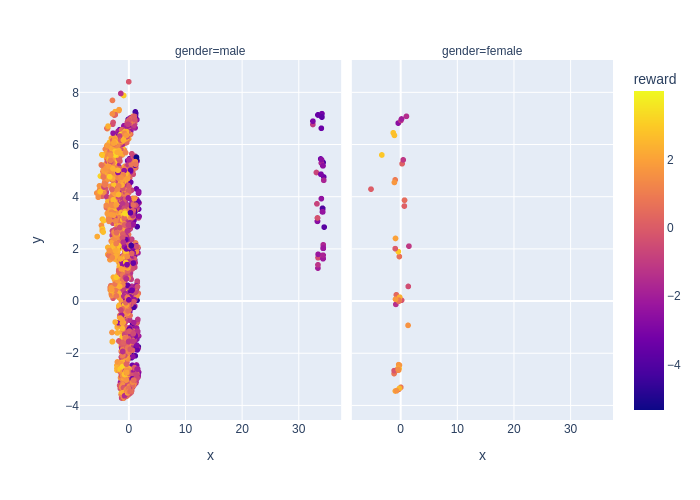

In [44]:
fig = px.scatter(
    eda_df.sample(10000), 
    x='x', 
    y='y', 
    color='reward', 
    facet_col='gender',
    # hover_data=['PatientID', 'TimePoint']
    )

fig.show('png')

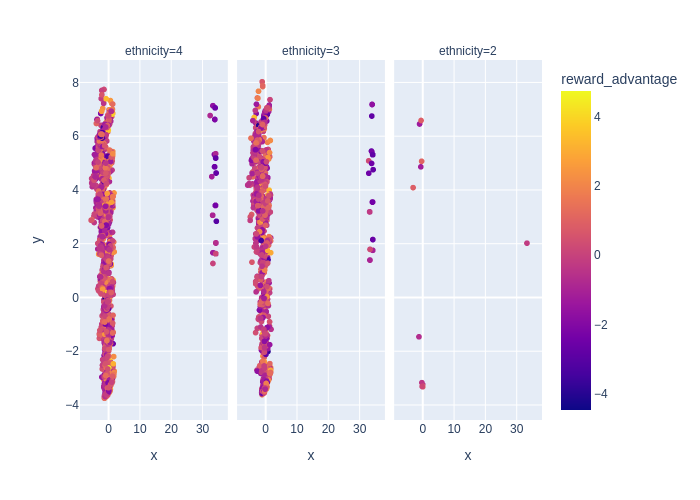

In [46]:
fig = px.scatter(
    eda_df.sample(10000), 
    x='x', 
    y='y', 
    color='reward_advantage', 
    facet_col='ethnicity',
    # hover_data=['PatientID', 'TimePoint']
    )

fig.show('png')

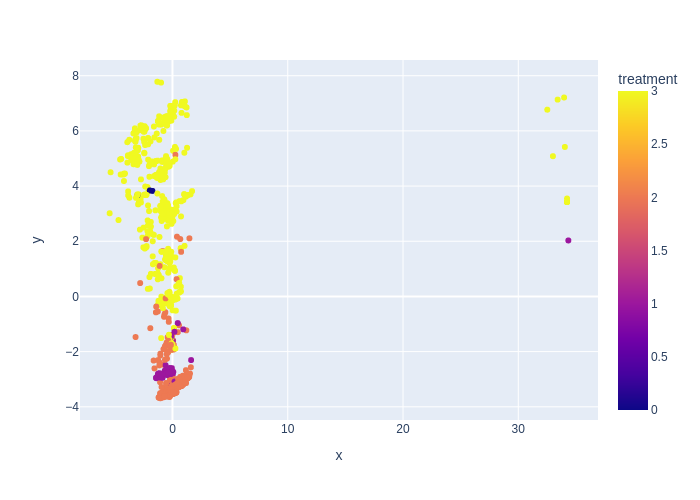

In [49]:
fig = px.scatter(
    eda_df.sample(1000), 
    x='x', 
    y='y', 
    color='treatment', 
    # facet_col='ethnicity',
    # hover_data=['PatientID', 'TimePoint']
    )

fig.show('png')

## t-SNE

In [14]:
%%time
tsne = TSNE(n_components=2)
X_tsne_2d = tsne.fit_transform(X_transformed)

results_df = pandas.DataFrame(dict(
    x=X_tsne_2d[:, 0],
    y=X_tsne_2d[:, 1],
    treatment=df_targets['treatment'],
    reward=df_targets['reward'] - df_targets['reward'].min(),
    reward_advantage=df_targets['reward_advantage']-df_targets['reward_advantage'].min(),
    patient_id=df_features['PatientID'],
    timepoint=df_features['Timepoints']
))

CPU times: user 12.1 ms, sys: 4 µs, total: 12.1 ms
Wall time: 11 ms


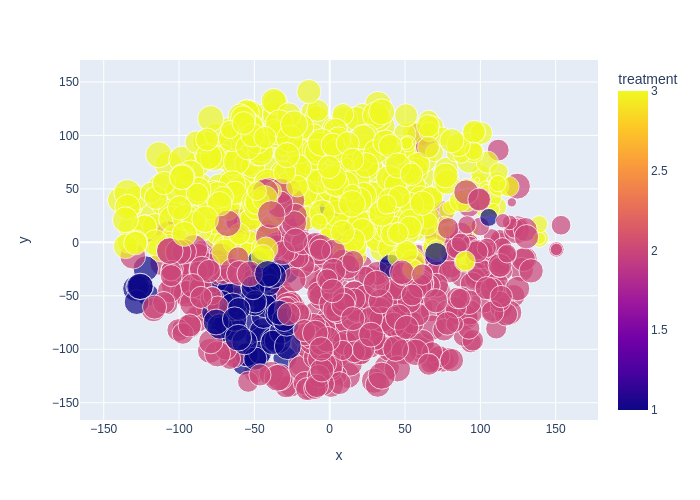

In [15]:
px.scatter(results_df.sample(1000), x='x', y='y', size='reward', color='treatment', hover_data=['patient_id', 'timepoint']).show('png')

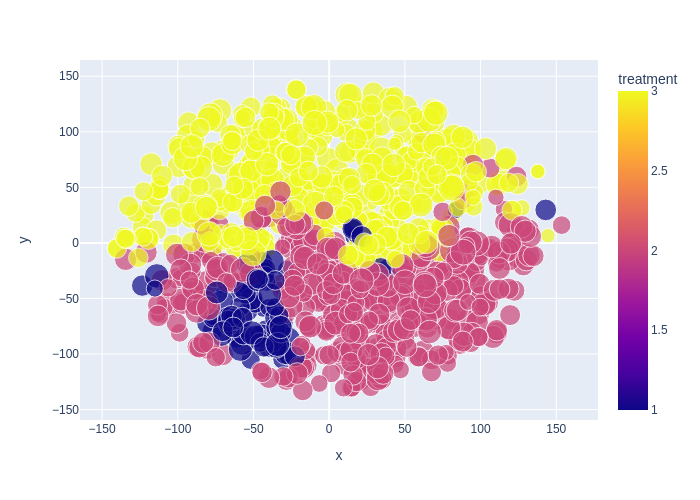

In [16]:
px.scatter(results_df.sample(1000), x='x', y='y', size='reward_advantage', color='treatment', hover_data=['patient_id', 'timepoint']).show('png')

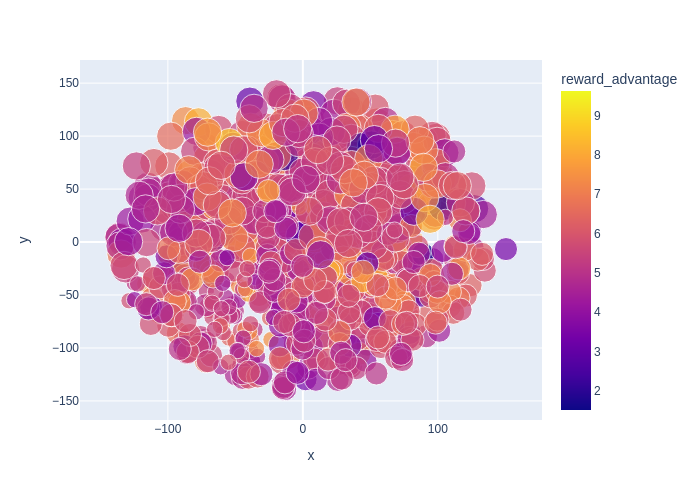

In [17]:
px.scatter(results_df.sample(1000), x='x', y='y', color='reward_advantage', size='treatment', hover_data=['patient_id', 'timepoint']).show('png')

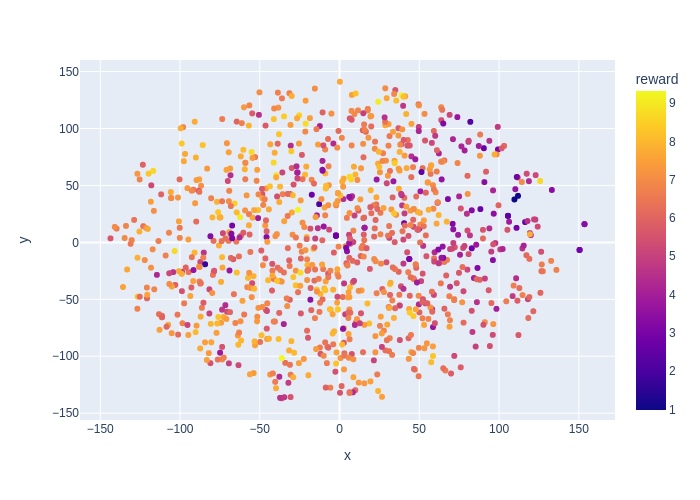

In [18]:
px.scatter(results_df.sample(1000), x='x', y='y', color='reward', hover_data=['patient_id', 'timepoint']).show('png')

In [50]:
%%time
eda_df = pandas.DataFrame(dict(
    x=X_tsne_2d[:, 0],
    y=X_tsne_2d[:, 1],
    PatientID=df_features['PatientID'],
    Timepoints=df_features['Timepoints']
))

def f(x):
    return 'male' if x['Gender_1.0'] == 1 else 'female'
df_features['gender'] = df_features.apply(f, axis=1)

def f(x):
    for i in [4, 3, 2]:
        if x[f'Ethnic_{i}.0'] == 1:
            return i
df_features['ethnicity'] = df_features.apply(f, axis=1)

eda_df = pandas.merge(eda_df, df_features, on=['PatientID', 'Timepoints'])
eda_df = pandas.merge(eda_df, df_targets, on=['PatientID', 'Timepoints'])

CPU times: user 5.34 s, sys: 1.17 s, total: 6.51 s
Wall time: 6.51 s


In [20]:
df_features.head()

PatientID  Timepoints  Comp. NNRTI_0.0  Comp. NNRTI_1.0  Comp. NNRTI_2.0  \
0          0    0.000000              0.0              1.0              0.0   
1          0    0.016667              0.0              0.0              0.0   
2          0    0.033333              0.0              0.0              0.0   
3          0    0.050000              0.0              0.0              0.0   
4          0    0.066667              0.0              0.0              0.0   

   Comp. NNRTI_3.0  Comp. INI_0.0  Comp. INI_1.0  Comp. INI_2.0  \
0              0.0            0.0            0.0            0.0   
1              1.0            0.0            0.0            0.0   
2              1.0            0.0            0.0            0.0   
3              1.0            0.0            0.0            0.0   
4              1.0            0.0            0.0            0.0   

   Comp. INI_3.0  ...  prev_month_Drug (M)_0.0_ewma  \
0            1.0  ...                     -1.000000   
1            1.0  ...                      1.000000   
2            1.0  ...                      0.166667   
3            1.0  ...                      0.032258   
4            1.0  ...                      0.006410   

   prev_month_Drug (M)_1.0_ewma  prev_month_Extra PI_0.0_ewma  \
0                     -1.000000                          -1.0   
1                      0.000000                           0.0   
2                      0.833333                           0.0   
3                      0.967742                           0.0   
4                      0.993590                           0.0   

   prev_month_Extra PI_1.0_ewma  prev_month_Extra PI_2.0_ewma  \
0                          -1.0                          -1.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   prev_month_Extra PI_3.0_ewma  prev_month_Extra PI_4.0_ewma  \
0                          -1.0                          -1.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   prev_month_Extra PI_5.0_ewma  prev_month_Extra pk-En_0.0_ewma  \
0                          -1.0                             -1.0   
1                           1.0                              1.0   
2                           1.0                              1.0   
3                           1.0                              1.0   
4                           1.0                              1.0   

   prev_month_Extra pk-En_1.0_ewma  
0                             -1.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0  

[5 rows x 116 columns]

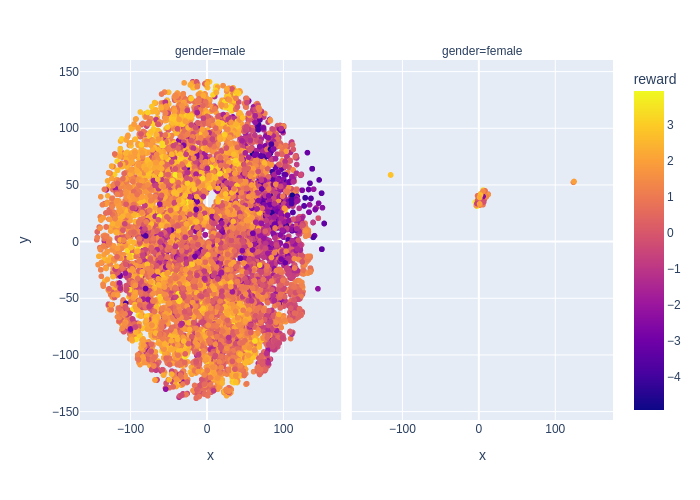

In [36]:
fig = px.scatter(
    eda_df.sample(10000), 
    x='x', 
    y='y', 
    color='reward', 
    facet_col='gender',
    # hover_data=['PatientID', 'TimePoint']
    )

fig.show('png')

In [42]:
fig = px.scatter(
    eda_df[eda_df.gender == 'female'], 
    x='x', 
    y='y', 
    color='reward', 
    facet_col='gender',
    # hover_data=['PatientID', 'TimePoint']
    )

fig.show()

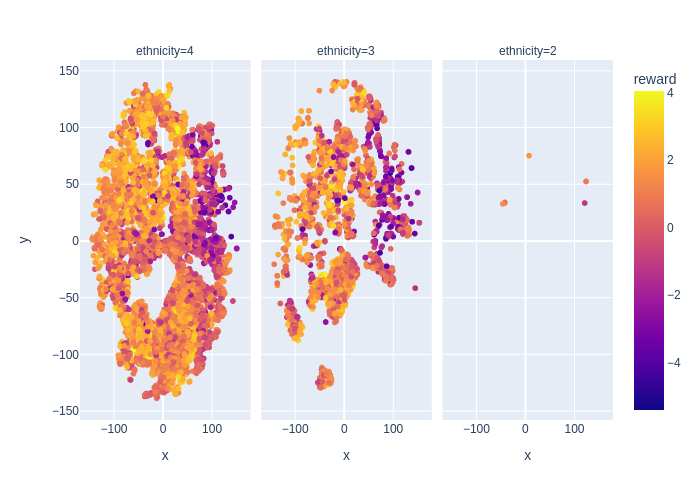

In [37]:
fig = px.scatter(
    eda_df.sample(10000), 
    x='x', 
    y='y', 
    color='reward', 
    facet_col='ethnicity',
    # hover_data=['PatientID', 'TimePoint']
    )

fig.show('png')

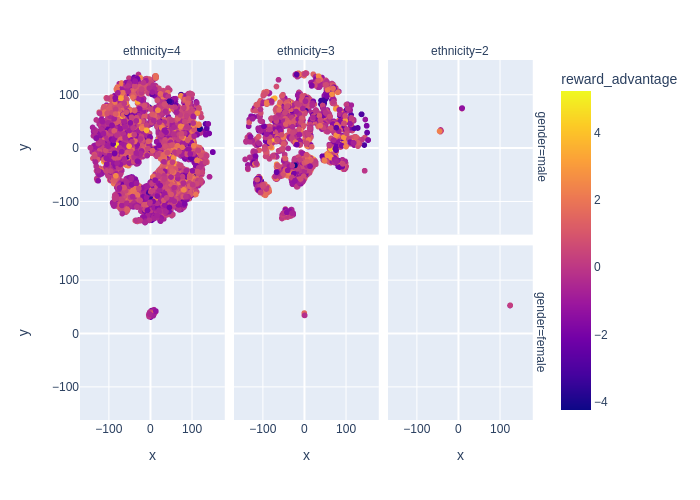

In [39]:
fig = px.scatter(
    eda_df.sample(10000), 
    x='x', 
    y='y', 
    color='reward_advantage', 
    facet_col='ethnicity',
    facet_row='gender'
    # hover_data=['PatientID', 'TimePoint']
    )

fig.show('png')

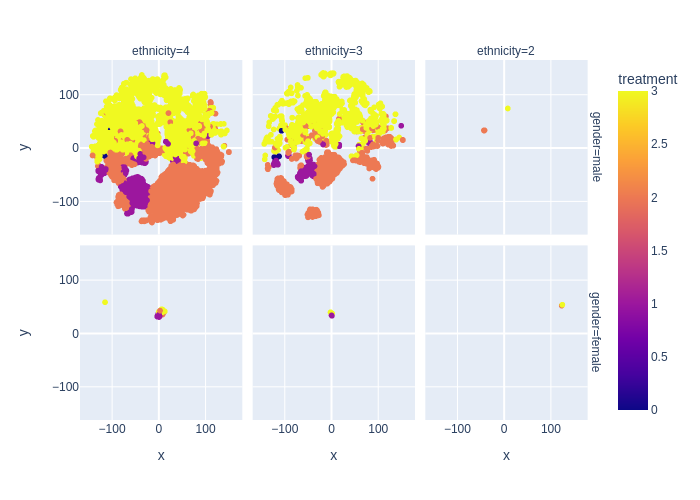

In [51]:
fig = px.scatter(
    eda_df.sample(10000), 
    x='x', 
    y='y', 
    color='treatment', 
    facet_col='ethnicity',
    facet_row='gender'
    # hover_data=['PatientID', 'TimePoint']
    )

fig.show('png')

In [53]:
fig = px.scatter(
    eda_df[eda_df.gender=='female'], 
    x='x', 
    y='y', 
    color='treatment', 
    facet_col='ethnicity',
    facet_row='gender'
    # hover_data=['PatientID', 'TimePoint']
    )

fig.show()

In [ ]:
eda_df.columns.tolist()

In [25]:
df_features.describe().transpose()

count         mean          std  min  \
PatientID                        534960.0  4457.500000  2573.829889  0.0   
Timepoints                       534960.0     0.491667     0.288635  0.0   
Comp. NNRTI_0.0                  534960.0     0.001935     0.043943  0.0   
Comp. NNRTI_1.0                  534960.0     0.092691     0.289999  0.0   
Comp. NNRTI_2.0                  534960.0     0.437580     0.496089  0.0   
...                                   ...          ...          ...  ...   
prev_month_Extra PI_3.0_ewma     534960.0     0.003072     0.176830 -1.0   
prev_month_Extra PI_4.0_ewma     534960.0     0.024707     0.222180 -1.0   
prev_month_Extra PI_5.0_ewma     534960.0     0.848055     0.392830 -1.0   
prev_month_Extra pk-En_0.0_ewma  534960.0     0.934349     0.305043 -1.0   
prev_month_Extra pk-En_1.0_ewma  534960.0     0.015651     0.217063 -1.0   

                                         25%          50%        75%  \
PatientID                        2228.750000  4457.500000  6686.2500   
Timepoints                          0.245833     0.491667     0.7375   
Comp. NNRTI_0.0                     0.000000     0.000000     0.0000   
Comp. NNRTI_1.0                     0.000000     0.000000     0.0000   
Comp. NNRTI_2.0                     0.000000     0.000000     1.0000   
...                                      ...          ...        ...   
prev_month_Extra PI_3.0_ewma        0.000000     0.000000     0.0000   
prev_month_Extra PI_4.0_ewma        0.000000     0.000000     0.0000   
prev_month_Extra PI_5.0_ewma        1.000000     1.000000     1.0000   
prev_month_Extra pk-En_0.0_ewma     1.000000     1.000000     1.0000   
prev_month_Extra pk-En_1.0_ewma     0.000000     0.000000     0.0000   

                                         max  
PatientID                        8915.000000  
Timepoints                          0.983333  
Comp. NNRTI_0.0                     1.000000  
Comp. NNRTI_1.0                     1.000000  
Comp. NNRTI_2.0                     1.000000  
...                                      ...  
prev_month_Extra PI_3.0_ewma        0.998464  
prev_month_Extra PI_4.0_ewma        0.993344  
prev_month_Extra PI_5.0_ewma        1.000000  
prev_month_Extra pk-En_0.0_ewma     1.000000  
prev_month_Extra pk-En_1.0_ewma     1.000000  

[116 rows x 8 columns]

In [59]:
eda_df.groupby(['gender', 'ethnicity']).mean().transpose().to_excel('a.xlsx')

In [32]:
eda_df.group

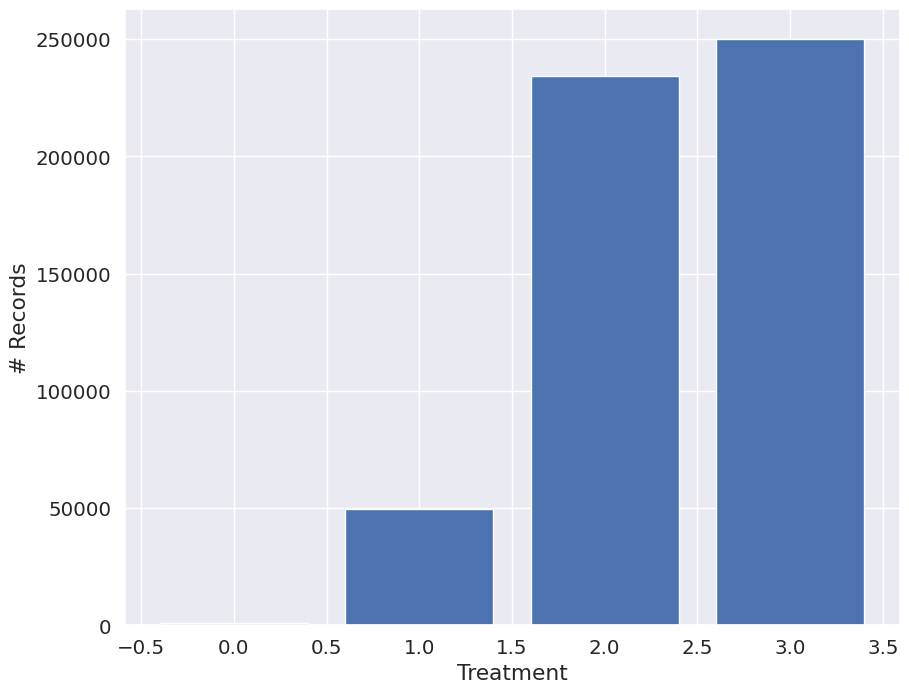

In [70]:
plt.figure()

plt.bar([0,1,2,3], eda_df.groupby('treatment').count().x)
plt.xlabel('Treatment')
plt.ylabel('# Records')
plt.show()

In [69]:
eda_df.groupby('treatment').count().x

treatment
0      1035
1     49586
2    234088
3    250251
Name: x, dtype: int64

In [74]:
eda_df.groupby(['treatment', 'gender', 'ethnicity']).describe().loc[:, 'reward_advantage']

count      mean       std       min       25%  \
treatment gender ethnicity                                                     
0         female 4               4.0 -1.970072  0.515315 -2.481286 -2.377115   
          male   3             521.0 -1.589760  0.391270 -3.019892 -1.834982   
                 4             510.0 -1.596800  0.421822 -3.011545 -1.895345   
1         female 2               1.0 -0.212214       NaN -0.212214 -0.212214   
                 3              71.0  0.061974  0.992454 -3.142996 -0.429852   
                 4             559.0  0.038931  1.018955 -3.735558 -0.591667   
          male   2              17.0  0.334768  1.083185 -1.827344 -0.065871   
                 3           11516.0  0.062552  1.126263 -4.351615 -0.738973   
                 4           37422.0  0.009652  1.111449 -4.789549 -0.797720   
2         female 2              58.0  0.043567  0.830113 -1.548281 -0.567616   
                 3               5.0  0.955141  0.740135  0.099614  0.252287   
                 4             541.0 -0.055859  0.917521 -2.762825 -0.786222   
          male   2             153.0  0.009708  0.999046 -2.038772 -0.730279   
                 3           65229.0  0.031044  1.111549 -4.823552 -0.768387   
                 4          168102.0  0.037687  1.112412 -4.940987 -0.760221   
3         female 2              61.0  0.065992  0.735577 -1.421332 -0.312750   
                 3             104.0 -0.001775  1.450812 -4.520533 -0.692720   
                 4            1176.0  0.118091  1.234068 -4.234630 -0.692635   
          male   2             250.0  0.061738  1.093303 -2.905437 -0.843169   
                 3           78914.0  0.064940  1.179718 -5.187600 -0.697053   
                 4          169746.0  0.065839  1.165228 -5.554885 -0.671237   

                                 50%       75%       max  
treatment gender ethnicity                                
0         female 4         -1.963567 -1.556523 -1.471868  
          male   3         -1.565787 -1.345998  0.213273  
                 4         -1.570672 -1.329352 -0.000746  
1         female 2         -0.212214 -0.212214 -0.212214  
                 3         -0.050875  0.725482  2.335985  
                 4         -0.090651  0.527713  3.816026  
          male   2          0.439308  1.174334  2.262733  
                 3         -0.030953  0.789028  4.593906  
                 4         -0.110983  0.807203  4.939011  
2         female 2         -0.025038  0.584053  1.652115  
                 3          1.160835  1.567922  1.695047  
                 4         -0.052841  0.633840  2.549030  
          male   2          0.032058  0.821334  3.194218  
                 3          0.045626  0.790749  4.429102  
                 4          0.073020  0.788569  4.943325  
3         female 2          0.069278  0.397414  2.583437  
                 3          0.285616  1.007266  2.192257  
                 4          0.110165  0.937310  4.570197  
          male   2          0.058396  0.885317  2.773856  
                 3          0.063557  0.839294  5.937172  
                 4          0.036328  0.814980  6.135069

In [75]:
eda_df.groupby(['treatment']).describe().loc[:, 'reward_advantage']

count      mean       std       min       25%       50%  \
treatment                                                               
0            1035.0 -1.594699  0.407321 -3.019892 -1.857958 -1.568753   
1           49586.0  0.022449  1.113929 -4.789549 -0.782963 -0.089839   
2          234088.0  0.035623  1.111635 -4.940987 -0.762426  0.064869   
3          250251.0  0.065769  1.170122 -5.554885 -0.679255  0.045383   

                75%       max  
treatment                      
0         -1.337565  0.213273  
1          0.801372  4.939011  
2          0.788838  4.943325  
3          0.823169  6.135069

In [77]:
eda_df['VL'].min()

0.9131532

In [83]:
eda_df[eda_df['reward_advantage']>2.0].groupby(['treatment','Timepoints']).count().loc[:, ['x']].transpose()

treatment         1                                                        \
Timepoints 0.016667 0.033333 0.050000 0.066667 0.083333 0.100000 0.116667   
x                26      183      109       94       60       25      112   

treatment                              ...        3                    \
Timepoints 0.133333 0.150000 0.166667  ... 0.833333 0.850000 0.866667   
x                47       64       17  ...      179       10       33   

treatment                                                                  
Timepoints 0.883333 0.900000 0.916667 0.933333 0.950000 0.966667 0.983333  
x                52       90       18      153       11       33       40  

[1 rows x 178 columns]